# **発電量のデータを分析する**

### **必要な関数・モジュール**

In [25]:
# データ加工・処理・分析モジュール
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import random

%matplotlib inline

import time

In [2]:
def set_time(dataframe, col_name):
    '''
    to_datetimeを使うための前処理
    '''
    dataframe[col_name] = dataframe[col_name].map(lambda x : transform_time(x))
    return dataframe

In [3]:
def transform_time(x):
    '''
    set_time内で使う関数
    to_datetimeで24時をサポートしないので00に変更する処理
    '''
    str_x = str(x)
    res = ''
    if str(x)[8:10] == '24':
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' 00:'+str_x[10:12] 
    else:
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' '+ str_x[8:10] +':'+str_x[10:12]
    return res

In [12]:
def get_hours(x):
    '''
    時間帯毎に分類するための関数
    '''
    num = 0
    num += int(x.hour) * 2
    if int(x.minute) == 30:
        num += 1
    return num

In [26]:
def denormalize_array(normalized_x, x_min, x_max):
    '''
    正規化前のmin, maxを用いて元のスケールに戻す
    '''
    normalized_x = np.array(normalized_x)
    denormalize_array = (normalized_x) * (x_max - x_min) + x_min
    return denormalize_array

In [27]:
def get_input_data(X):
    '''
    全時系列データから00:00 ~ 20:00までのデータごとに分割する
    '''
    input_list = []
    # 一日は48個の時間帯に分けられる
    total_size = len(X) // 48
    reshaped_size = X[0:41].shape[0] * X[0:41].shape[1]
    for i in range(total_size+1):
        each_data = X[(i*48):(i*48+41)]
        reshaped = each_data.reshape(reshaped_size)
        input_list.append(list(reshaped))
    input_list = np.array(input_list)
    return input_list

In [28]:
def get_output_data(Y):
    '''
    全時系列データから00:00 ~ 23:30までのデータごとに分割する
    '''
    output_list = []
    # 一日は48個の時間帯に分けられる
    total_size = len(Y) // 48
    for i in range(total_size):
        each_data = Y[(i*48):(i*48+48)]
        reshaped = each_data.reshape(48)
        output_list.append(list(reshaped))
    output_list = np.array(output_list)
    return output_list

In [29]:
def drop_nan(X, Y):
    '''
    Yにnanが含まれるペアを削除(他のとこにあるdrop_nanとは別物なので注意)
    '''
    mask = []
    for i in range(len(Y)):
        if np.isnan(Y[i]).sum() == 0:
            mask.append(True)
        else:
            mask.append(False)
    X = X[mask]
    Y = Y[mask]
    return X, Y

In [30]:
def calc_mae(X, Y):
    '''
    X, Yがメモリを食いすぎるのでfor文で計算
    '''
    mse = 0
    for i in range(len(X)):
        mse += np.abs(X[i]- Y[i])
    return mse/len(X)

### **データを読み込む**

In [4]:
# 発電量データ
output_data = pd.read_csv('data/raw_data/train_kwh.tsv', delimiter = '\t')
output_data = set_time(output_data, 'datetime')
output_data['datetime'] = output_data['datetime'].map(lambda x : pd.to_datetime(x))

In [5]:
output_30 = output_data.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()
output_30['datetime'] = output_30.index
output_30.index = np.arange(len(output_30))

In [7]:
output_30_1 = output_30[['datetime', 'SOLA01']]
output_30_2 = output_30[['datetime', 'SOLA02']]
output_30_3 = output_30[['datetime', 'SOLA03']]

In [37]:
output_30_1['hours'] = output_30_1['datetime'].map(lambda x: get_hours(x))
output_30_1['month'] = output_30_1['datetime'].map(lambda x: x.month)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [41]:
groupby_hours_1 = output_30_1.groupby(['hours'], as_index=False).mean()

In [42]:
groupby_hours_1

,hours,SOLA01,month
0,0,0.000000,6.52293
1,1,0.000000,6.52293
2,2,0.000000,6.52293
3,3,0.000000,6.52293
4,4,0.000000,6.52293
5,5,0.000000,6.52293
6,6,0.000000,6.52293
7,7,0.000000,6.52293
8,8,0.000000,6.52293
9,9,0.086927,6.52293


In [43]:
left = np.array(groupby_hours_1['hours'])
height = np.array(groupby_hours_1['SOLA01'])

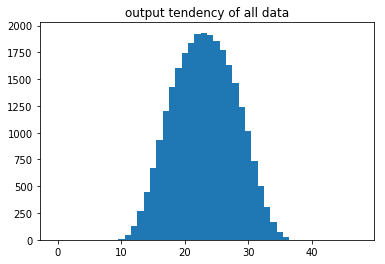

In [45]:
plt.bar(left, height, width=1.0)
plt.title("output tendency of all data")

** 0:00 ~ 4:00, 19:00 ~ 23:30の間は3年間一度も発電してない(当たり前) ** 

In [48]:
groupby_hours_and_month_1 = output_30_1.groupby(['month', 'hours'], as_index=False).mean()

In [49]:
groupby_hours_and_month_1

,month,hours,SOLA01
0,1,0,0.000000
1,1,1,0.000000
2,1,2,0.000000
3,1,3,0.000000
4,1,4,0.000000
5,1,5,0.000000
6,1,6,0.000000
7,1,7,0.000000
8,1,8,0.000000
9,1,9,0.000000
